일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 torch.*Tensor 로 변환합니다.

이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.

오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.

텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도 유용합니다.

특별히 영상 분야를 위한 torchvision 이라는 패키지가 만들어져 있는데, 여기에는 Imagenet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader), 즉 torchvision.datasets 과 이미지용 데이터 변환기 (data transformer), 즉 torch.utils.data.DataLoader 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서 작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이 있습니다: ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’. 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


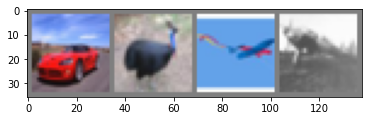

  car  bird plane plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

input shape: 3x32x32

conv1 output: (32 - 5 + 2*0)/1 + 1 = 28  >> 6x28x28

pooling output: 6x14x14

conv2 output: (14 - 5 + 2*0)/1 + 1 = 10  >> 16x10x10

pooling output: 16x5x5 

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.180
[1,  4000] loss: 1.837
[1,  6000] loss: 1.671
[1,  8000] loss: 1.597
[1, 10000] loss: 1.540
[1, 12000] loss: 1.473
[2,  2000] loss: 1.406
[2,  4000] loss: 1.376
[2,  6000] loss: 1.345
[2,  8000] loss: 1.298
[2, 10000] loss: 1.279
[2, 12000] loss: 1.270
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)